# Is the SAT unfair?  Exploring and visualizing the data to find out

### Goal of this project


### Approach


### Summary of results



# Introduction to the data

The csv file `nyc_hs_data_clean.csv` located in the `data/processed` folder of this project was produced by running the `cleaning-nyc-hs-data` project, which can be found [here](https://github.com/JustinToribio/cleaning-nyc-hs-data).  We will read the csv file into a dataframe named `data` and view the first 5 rows.

There are 362 rows (1 for each school) and 79 columns in `data`, which contains NYC SAT results by school for the graduating seniors of 2012 in the first few columns.  At the time of this writing, this was the most recent SAT data available.  The remaining columns contain graduation, advanced placement (AP), class size, demographic, school survey and location data for the same school year (or as close to it as possible if the 2012 data was not available).

In [1]:
# Import pandas module and set maximum viewable columns and rows to 500.
import pandas as pd
pd.options.display.max_columns = 500  
pd.options.display.max_rows = 500

# Read csv file into a dataframe named "data" and view the first 5 rows.
data = pd.read_csv("../data/processed/nyc_hs_data_clean.csv")
data.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,Num of AP Test Takers,Num of AP Total Exams Taken,Num of AP Exams Passed,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_s_11,saf_t_11,saf_p_11,saf_tot_11,eng_s_11,eng_t_11,eng_p_11,eng_tot_11,aca_s_11,aca_t_11,aca_p_11,aca_tot_11,com_s_11,com_t_11,com_p_11,com_tot_11,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,1122.0,78.0,43.0,55.1,36.0,46.2,83.7,0.0,0.0,0.0,36.0,46.2,83.7,7.0,9.0,16.3,16.0,20.5,11.0,14.1,18.096134,19.175354,13.554735,88.000000,4.000000,22.564286,18.500000,26.571429,88.6,422.0,94.0,22.3,105.0,24.9,34.0,35.0,59.0,14.0,123.0,29.1,227.0,53.8,7.0,1.7,259.0,61.4,163.0,38.6,89.0,70.0,39.0,379.000000,26.0,151.0,6.00000,6.3,7.8,6.7,6.100000,6.1,7.4,6.6,6.700000,6.5,7.6,7.0,5.600000,5.3,7.7,6.2,40.713764,-73.985260,1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,1172.0,124.0,53.0,42.7,42.0,33.9,79.2,8.0,6.5,15.1,34.0,27.4,64.2,11.0,8.9,20.8,46.0,37.1,20.0,16.1,37.000000,53.000000,21.000000,105.687500,4.750000,22.231250,18.250000,27.062500,71.8,394.0,83.0,21.1,86.0,21.8,55.0,10.0,115.0,29.2,89.0,22.6,181.0,45.9,9.0,2.3,226.0,57.4,168.0,42.6,84.0,95.0,10.0,385.000000,37.0,46.0,6.00000,6.6,7.9,6.8,6.300000,6.6,7.2,6.7,7.000000,7.3,7.3,7.2,5.700000,5.8,7.4,6.3,40.712332,-73.984797,1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,1149.0,90.0,70.0,77.8,67.0,74.4,95.7,0.0,0.0,0.0,67.0,74.4,95.7,3.0,3.3,4.3,15.0,16.7,5.0,5.6,12.000000,12.000000,20.562084,57.600000,2.733333,21.200000,19.400000,22.866667,71.8,598.0,30.0,5.0,158.0,26.4,91.0,19.0,58.0,9.7,143.0,23.9,331.0,55.4,62.0,10.4,327.0,54.7,271.0,45.3,0.0,98.0,28.0,422.207196,42.0,150.0,6.79888,7.3,8.7,7.9,6.832925,8.0,8.1,7.9,7.594217,8.8,8.4,8.4,6.151669,8.0,8.2,7.9,40.729783,-73.983041,1
3,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,1207.0,84.0,47.0,56.0,40.0,47.6,85.1,17.0,20.2,36.2,23.0,27.4,48.9,7.0,8.3,14.9,25.0,29.8,5.0,6.0,14.000000,15.000000,13.779655,69.642857,3.000000,23.571429,20.000000,27.357143,80.7,367.0,41.0,11.2,95.0,25.9,28.0,36.0,34.0,9.3,116.0,31.6,209.0,56.9,6.0,1.6,170.0,46.3,197.0,53.7,90.0,100.0,21.0,306.000000,29.0,69.0,6.40000,6.4,7.7,6.9,6.400000,6.1,7.2,6.6,7.000000,6.8,7.3,7.0,5.900000,5.3,7.4,6.2,40.720569,-73.985673,1
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159.0,522.0,574.0,525.0,1621.0,46.0,46.0,100.0,46.0,100.0,100.0,31.0,67.4,67.4,15.0,32.6,32.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.000000,587.000000,323.000000,156.368421,6.157895,25.510526,19.473684,31.210526,23.0,1613.0,4.0,0.2,43.0,2.7,2.0,0.0,448.0,27.8,189.0,11.7,229.0,14.2,725.0,44.9,794.0,49.2,819.0,50.8,98.0,68.0,51.0,923.000000,67.0,736.0,7.30000,7.6,8.5,7.8,7.000000,5.9,7.9,6.9,7.700000,7.3,8.4,7.8,6.400000,5.6,7.9,6.7,40.718725,-73.979426,1


# Finding correlations with the r value

In [2]:
correlations = data.corr()
correlations = correlations["sat_score"]
correlations

Num of SAT Test Takers                0.490236
SAT Critical Reading Avg. Score       0.986698
SAT Math Avg. Score                   0.972543
SAT Writing Avg. Score                0.987755
sat_score                             1.000000
Total Cohort                          0.338325
Total Grads - n                       0.450670
Total Grads - % of cohort             0.603151
Total Regents - n                     0.506568
Total Regents - % of cohort           0.704099
Total Regents - % of grads            0.537477
Advanced Regents - n                  0.598048
Advanced Regents - % of cohort        0.795067
Advanced Regents - % of grads         0.763957
Regents w/o Advanced - n              0.218151
Regents w/o Advanced - % of cohort   -0.109673
Regents w/o Advanced - % of grads    -0.434221
Local - n                            -0.025044
Local - % of cohort                  -0.514678
Local - % of grads                   -0.537477
Still Enrolled - n                    0.017713
Still Enrolle

# Plotting enrollment with the `plot()` accessor

0.380341094565637

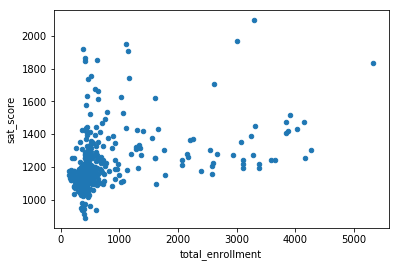

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

data.plot(x="total_enrollment", y="sat_score", kind="scatter")
correlations["total_enrollment"]

# Exploring schools with low SAT scores and enrollment

In [4]:
low_enrollment = data[data["total_enrollment"] < 1000]
low_enrollment = data[data["sat_score"] < 1000]
print(low_enrollment.shape)
low_enrollment[["SCHOOL NAME", "total_enrollment", "sat_score"]]

(12, 79)


,SCHOOL NAME,total_enrollment,sat_score
90,INTERNATIONAL COMMUNITY HIGH SCHOOL,393.0,945.0
124,ACADEMY FOR LANGUAGE AND TECHNOLOGY,336.0,951.0
125,BRONX INTERNATIONAL HIGH SCHOOL,403.0,965.0
138,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,497.0,962.0
140,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,606.0,934.0
175,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,406.0,970.0
178,HIGH SCHOOL OF WORLD CULTURES,369.0,939.0
187,BROOKLYN INTERNATIONAL HIGH SCHOOL,367.0,981.0
224,INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS,401.0,913.0
236,IT TAKES A VILLAGE ACADEMY,382.0,963.0


# Plotting language learning percentage

-0.4119382941227628

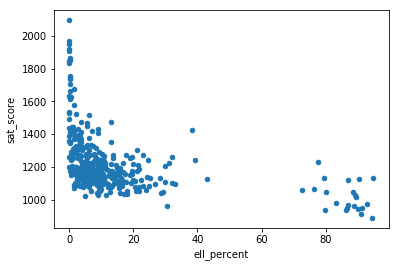

In [5]:
data.plot(x="ell_percent", y="sat_score", kind="scatter")
correlations["ell_percent"]

# Cartopy Experimenting

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

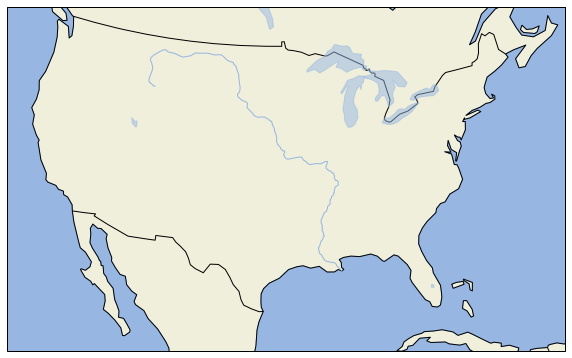

In [7]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection=ccrs.LambertConformal())

ax.add_feature(cfeat.LAND)
ax.add_feature(cfeat.OCEAN)
ax.add_feature(cfeat.BORDERS)
ax.add_feature(cfeat.COASTLINE)
ax.add_feature(cfeat.LAKES, alpha=0.5)
ax.add_feature(cfeat.RIVERS)

ax.set_extent((-120, -70, 20, 50))

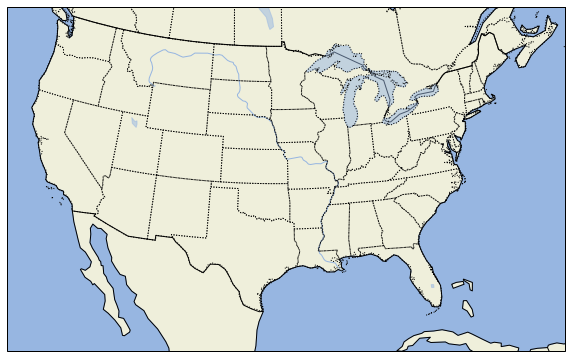

In [8]:
state_borders = cfeat.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                          scale='50m', facecolor='none')

ax.add_feature(state_borders, linestyle='dotted', edgecolor='black')

fig

In [9]:
proj = ccrs.Stereographic(central_longitude=-95, central_latitude=35)

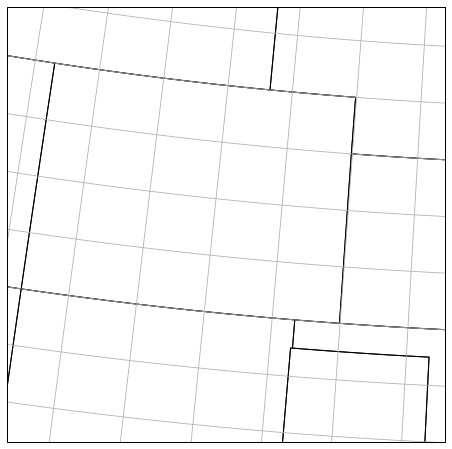

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=proj)
ax.add_feature(state_borders, edgecolor='black')
ax.add_feature(cfeat.BORDERS)
ax.gridlines()
ax.set_extent((-109, -100, 35, 42))

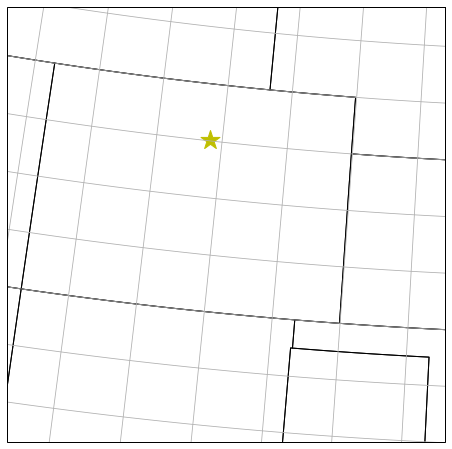

In [11]:
ax.scatter(-105.27, 40.01, transform=ccrs.PlateCarree(), marker='*', s=400, c='y')

fig

# Mapping the schools

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

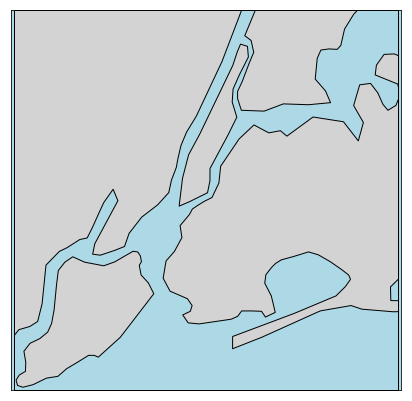

In [13]:
state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

fig = plt.figure(figsize=(7,7))

# make this subplot a little bit wider somehow???
ax1 = fig.add_subplot(111)
ax1.set_facecolor("lightblue")
ax1.tick_params(
    axis='both', which='both', bottom=False,
    top=False, left=False, right=False,
    labelleft=False, labelbottom=False
    )

ax2 = fig.add_subplot(111, projection=ccrs.Mercator())
ax2.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax2.background_patch.set_fill(False)
ax2.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

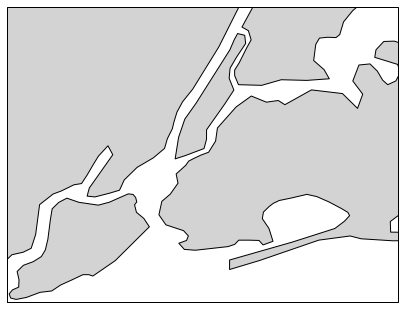

In [14]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

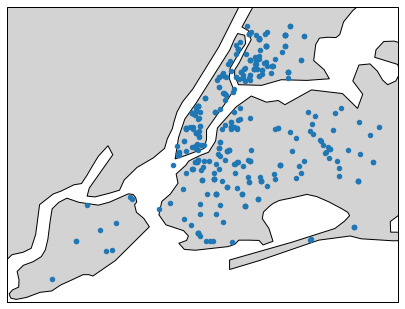

In [15]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = data["lon"].tolist()
latitudes = data["lat"].tolist()

ax.scatter(longitudes, latitudes, transform=ccrs.PlateCarree(), s=20, zorder=4)

# Plotting out statistics

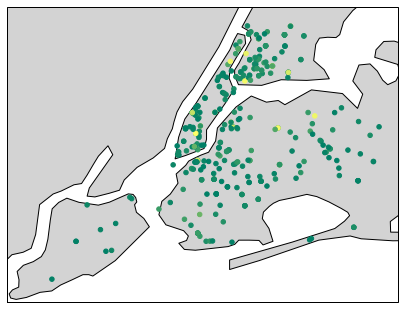

In [16]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

ax.scatter(longitudes, latitudes, s=20, zorder=2, c=data["ell_percent"], cmap="summer")

# Calculating district level statistics

In [17]:
import numpy as np

districts = data.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

districts.head()

,school_dist,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,Num of AP Test Takers,Num of AP Total Exams Taken,Num of AP Exams Passed,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_s_11,saf_t_11,saf_p_11,saf_tot_11,eng_s_11,eng_t_11,eng_p_11,eng_tot_11,aca_s_11,aca_t_11,aca_p_11,aca_tot_11,com_s_11,com_t_11,com_p_11,com_tot_11,lat,lon
0,1,87.166667,441.833333,473.333333,439.333333,1354.500000,93.500000,65.500000,71.333333,60.833333,66.416667,90.616667,9.333333,15.683333,19.783333,51.500000,50.733333,70.850000,4.666667,4.916667,9.383333,17.666667,17.833333,7.000000,7.083333,84.291336,139.752637,84.333827,115.244241,5.148538,22.675415,18.798392,26.553044,58.983333,668.500000,42.166667,10.000000,82.000000,17.083333,35.000000,16.666667,134.500000,17.516667,125.500000,22.333333,214.833333,40.733333,186.000000,18.450000,328.166667,50.050000,340.333333,49.950000,76.500000,85.333333,33.166667,496.034533,38.500000,239.166667,6.799813,7.066667,8.233333,7.433333,6.772154,6.700000,7.683333,7.116667,7.482369,7.500000,8.016667,7.683333,6.175278,6.233333,7.800000,6.816667,40.719022,-73.982377
1,2,109.337557,423.269446,438.595848,421.100185,1282.965479,138.697428,107.862897,75.666297,94.222360,64.302408,84.304987,35.251348,17.121937,19.667211,58.971012,47.169667,64.636568,13.640538,11.378324,15.695013,19.582217,14.611029,9.078776,7.215021,95.779461,146.635567,96.610208,149.818949,5.686360,25.038118,20.662667,28.593861,63.164583,605.604167,51.625000,13.006250,70.770833,13.212500,36.166667,11.541667,118.395833,14.479167,141.145833,24.733333,271.458333,49.554167,68.541667,10.056250,266.500000,44.718750,339.104167,55.281250,83.312500,86.416667,38.333333,489.850536,31.687500,190.000000,6.926629,7.404167,8.254167,7.520833,6.655288,7.120833,7.379167,7.037500,7.389787,7.564583,7.704167,7.541667,6.212715,6.520833,7.495833,6.720833,40.739699,-73.991386
2,3,111.330361,422.879310,428.509107,420.261663,1271.650079,149.088357,124.998519,73.870669,114.447834,62.946544,83.858510,35.486907,13.692338,16.475399,78.960927,49.263644,67.401518,10.550685,10.917248,16.141490,16.536632,15.611714,6.920222,7.279957,121.365416,189.175742,125.462201,156.005994,5.839200,23.716311,19.737593,27.122831,58.050000,661.416667,36.916667,9.025000,63.583333,14.500000,21.250000,15.583333,68.000000,6.408333,181.833333,34.000000,228.250000,44.533333,172.000000,13.725000,272.166667,47.950000,389.250000,52.050000,83.166667,80.833333,36.166667,519.250000,28.166667,206.416667,6.716667,6.675000,8.316667,7.233333,6.633333,6.533333,7.508333,6.891667,7.375000,6.991667,7.758333,7.391667,6.258333,5.991667,7.541667,6.616667,40.781574,-73.977370
3,4,108.000000,397.166667,411.333333,398.666667,1207.166667,123.666667,96.000000,72.300000,79.666667,52.750000,69.966667,37.833333,13.716667,16.266667,41.833333,39.033333,53.700000,16.333333,19.550000,30.033333,17.666667,16.983333,6.500000,7.633333,76.362637,102.588809,60.413375,143.040289,5.607065,23.832596,19.197619,27.380143,71.616667,589.333333,23.500000,4.950000,63.333333,14.300000,30.000000,11.000000,67.500000,6.300000,153.666667,29.833333,353.500000,61.616667,9.666667,1.266667,225.500000,35.600000,363.833333,64.400000,88.000000,92.16666

# Plotting "percent of English learners" by district

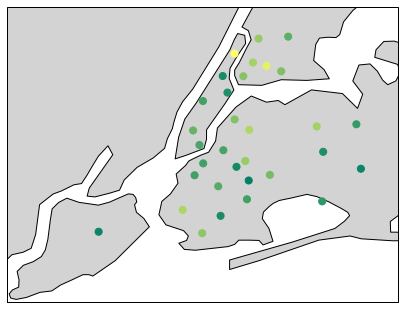

In [18]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

ax.scatter(longitudes, latitudes, s=50, zorder=2, c=districts["ell_percent"], cmap="summer")

# Correlation between survey results and SAT scores

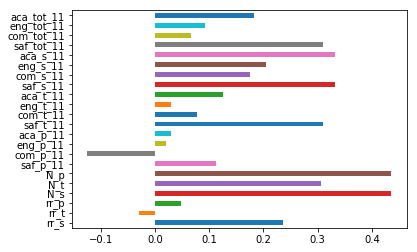

In [19]:
survey_fields_with_SAT = [
    "DBN",
    "sat_score",
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
    ]

corr_survey_sat = data.loc[:, survey_fields_with_SAT].corr()
corr_survey_sat = corr_survey_sat["sat_score"][1:]

corr_survey_sat.plot.barh()

Mine: Academic expectations and safety and respect scores have strong r-values with SAT scores. Makes sense, hard to learn in an unsafe environment, and I'd expect high achieving students with high expectations of a school to perform well academically at that school.

Solution: There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers perceived safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Exploring safety and SAT scores

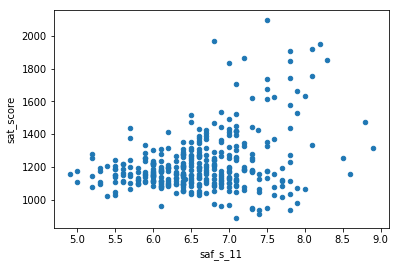

In [20]:
data.plot.scatter(x='saf_s_11', y='sat_score')

Mine: Doesn't appear to be a strong linear correlations, weak at best.

Solution: There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

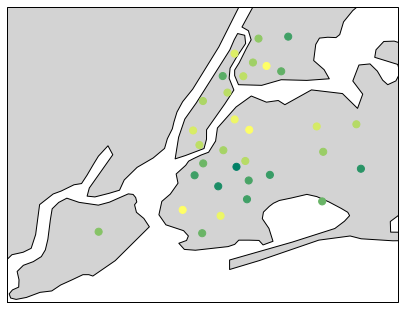

In [21]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

ax.scatter(longitudes, latitudes, s=50, zorder=2, c=districts["saf_s_11"], cmap="summer")

Mine: Safest schools are in Manhattan as expected. With exception of a few, the least safe schools are in Brooklyn, Queens and the Bronx

Solution: It looks like Upper Manhattan and parts of Queens and the Bronx tend to have lower safety scores, whereas Brooklyn has high safety scores.

# Exploring race and SAT scores

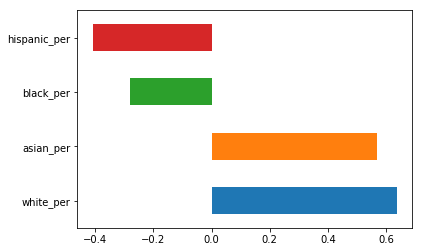

In [22]:
race_cols = ["sat_score", "white_per", "asian_per", "black_per", "hispanic_per"]
race_sat = data[race_cols].corr()["sat_score"][1:]
race_sat.plot.barh()

Mine: Asian and White are strongly positively correlated. Hispanic and Black are strongly negatively correlated.  Possibly suggests racial bias in test, or indicative of lack of funding for schools in areas with high % of hispanic and black students.

Solution: It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

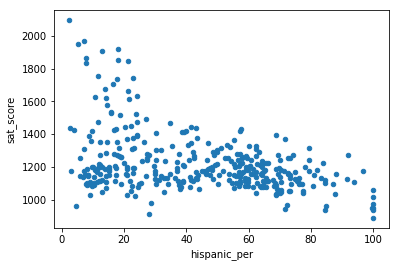

In [23]:
data.plot.scatter("hispanic_per", "sat_score")

Mine: appears to be negative correlation, although not that strong. Schools with greater than approx 25% Hispanic don't have an SAT score above around 1500

In [24]:
data[data["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
81      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
88     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
124                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
140                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
175     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
252                            MULTICULTURAL HIGH SCHOOL
285               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Solution: The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [25]:
hisp_10_1800 = data[data["hispanic_per"] < 10]
hisp_10_1800[hisp_10_1800["sat_score"] > 1800]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
150                         BRONX HIGH SCHOOL OF SCIENCE
186                       BROOKLYN TECHNICAL HIGH SCHOOL
326    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
355                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Mine: all appear to be science and technical schools, suggesting higher acceptance requirements, and hence higher achieving students

Solution: Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Exploring gender and SAT scores

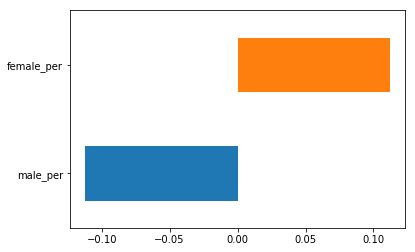

In [26]:
sex_cols = ["sat_score", "male_per", "female_per"]
sex_sat = data[sex_cols].corr()["sat_score"][1:]
sex_sat.plot.barh()

Mine: females positive corr, males negative corr, but neither are strong.

Solution: In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

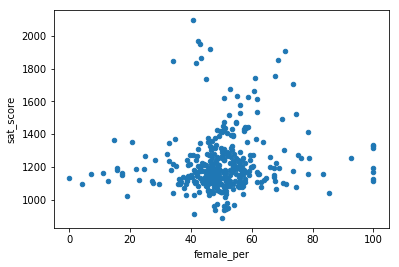

In [27]:
data.plot.scatter("female_per", "sat_score")

Mine: don't see any strong linear corr.  There's high and low sat scores with high and low female_per

Solution: Based on the scatter plot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [28]:
fem_60_1700 = data[data["female_per"] > 60]
fem_60_1700[fem_60_1700["sat_score"] > 1700]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
301                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Solution: These schools appears to be very selective liberal arts schools that have high academic standards

# Exploring AP scores vs SAT scores

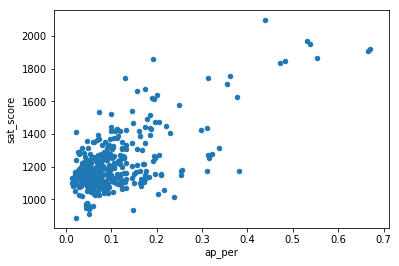

In [29]:
data["ap_per"] = data["Num of AP Test Takers"] / data["total_enrollment"]
data.plot.scatter("ap_per", "sat_score")

Mine: some corr but not strong. There is a cluster of schools with ap_per > .4 with high SAT, but also a bunch with very high ap_per with SAT no greater than 1200

Solution: It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

# Conclusion